In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from isochrones.mist.bc import MISTBolometricCorrectionGrid

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
bands = ["G", "BP", "RP"]

grid = MISTBolometricCorrectionGrid(bands=bands)
df = grid.df

points = [df.index.unique(level=name).to_numpy() for name in df.index.names]
shape = [x.shape[0] for x in points]
values = np.reshape(df[bands].to_numpy(), shape + [len(bands),])

In [3]:
interpolator = RegularGridInterpolator(points, values, method="linear")

In [4]:
from scipy.stats.qmc import Sobol

In [5]:
ndim = len(points)
minval = [np.log10(2.5) + 3, 2.0, -1.0, 0.0]
maxval = [np.log10(2.5) + 4, 6.0, 0.5, 4.0]

In [6]:
m = 23
sobol = Sobol(ndim)
scaled_inputs = sobol.random_base2(m)
inputs = np.add(minval, scaled_inputs * np.subtract(maxval, minval))
inputs[:, 0] = 10**inputs[:, 0]

In [7]:
def function_to_emulate(inputs):
    y = interpolator(inputs)
    return y
    # return np.stack([y[:, 0], y[:, 2] - y[:, 1]], -1)

In [8]:
outputs = function_to_emulate(inputs)

In [9]:
import seaborn as sns
import pandas as pd

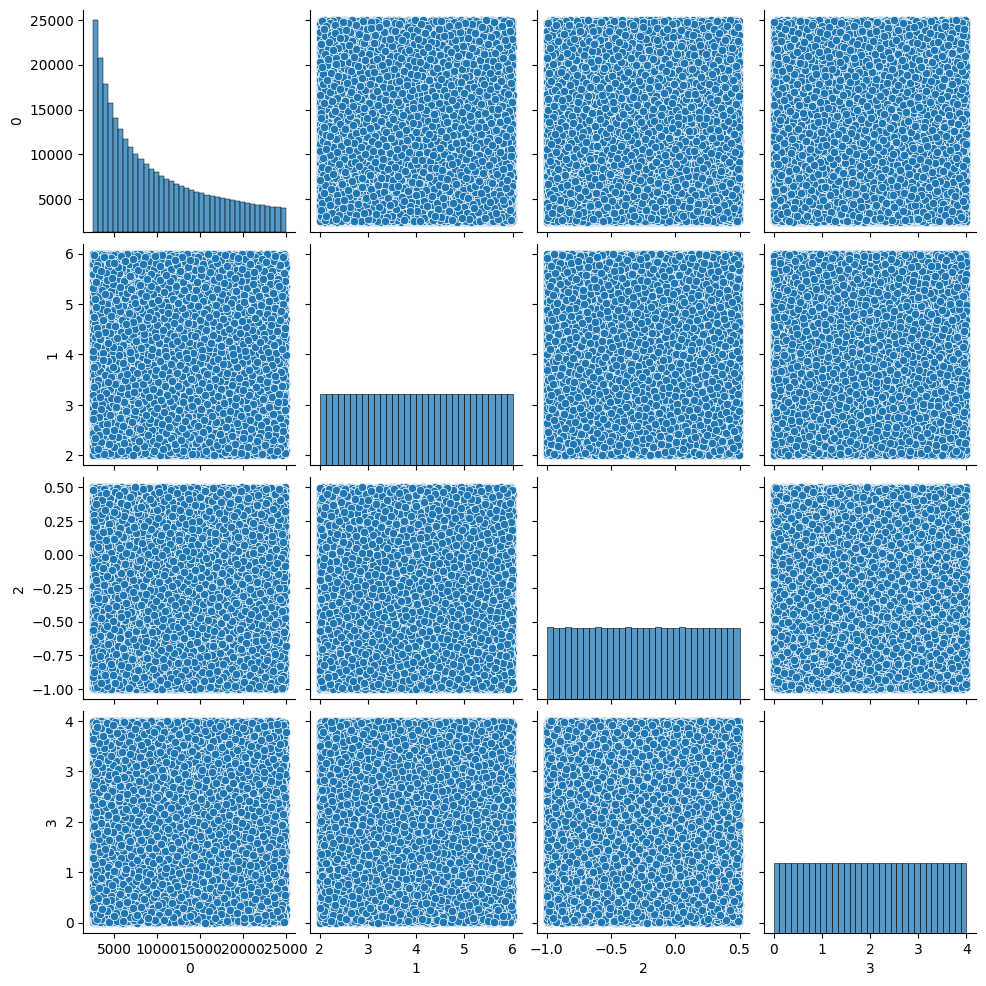

In [10]:
sns.pairplot(pd.DataFrame(inputs[:2**15]))

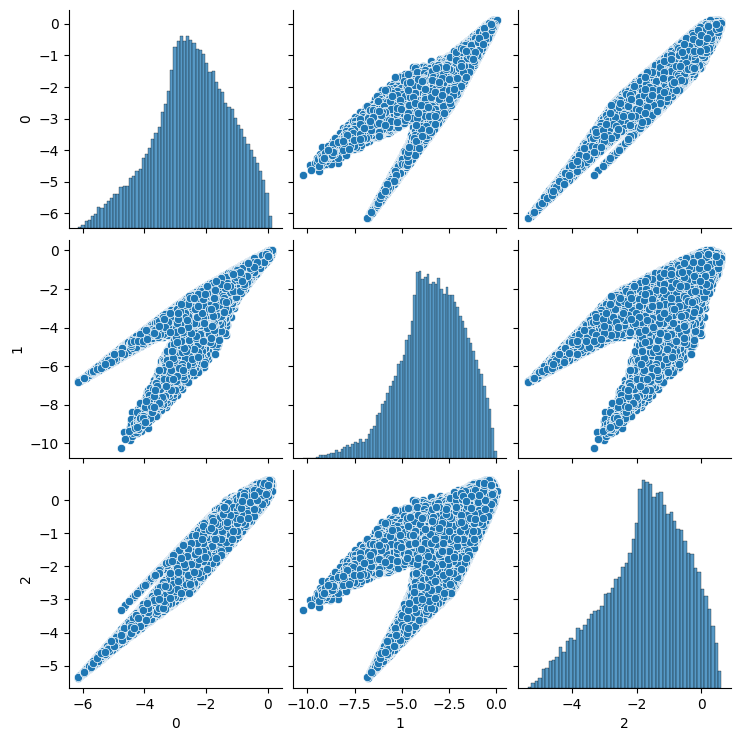

In [11]:
sns.pairplot(pd.DataFrame(outputs[:2**15]))

Our inputs are the scaled samples from the sobol sequence, these will always be between 0 and 1.

In [12]:
loc, scale = outputs.mean(0), outputs.std(0)
scaled_outputs = (outputs - loc) / scale

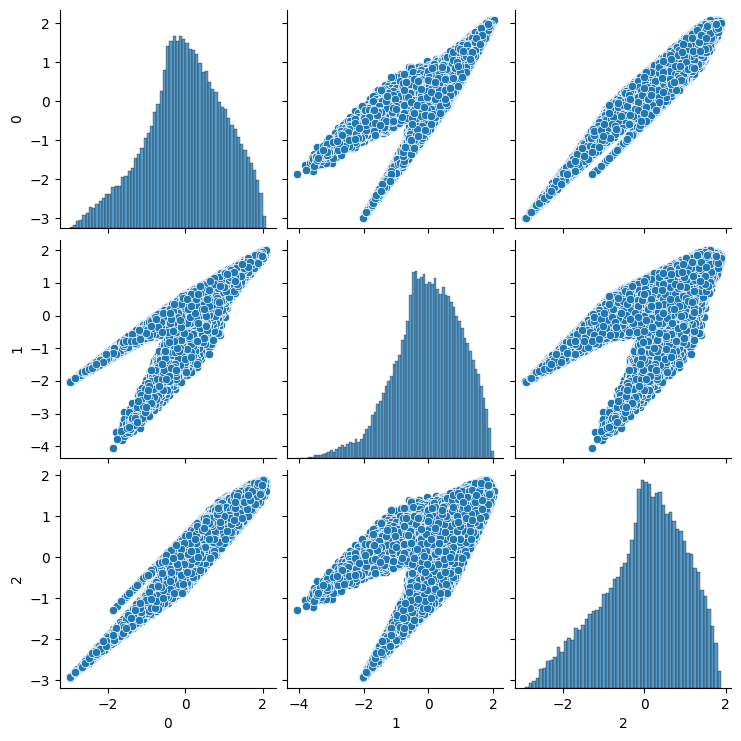

In [13]:
sns.pairplot(pd.DataFrame(scaled_outputs[:2**15]))

In [14]:
n = int(2**m)
test_index = np.random.choice(n, size=n//5, replace=False)
train_mask = np.ones(n, dtype=bool)
train_mask[test_index] = False

In [15]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2024-01-26 16:57:21.971973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 16:57:21.972002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 16:57:21.972964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 16:57:21.977899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 16:57:22.562853: W tensorflow/compiler/tf2

2.15.0


In [16]:
activation = "relu"
arch = (6, 64)

model = tf.keras.Sequential(
    [layers.Dense(arch[1], activation) for _ in range(arch[0])] +
    [layers.Dense(scaled_outputs.shape[-1])]
)

2024-01-26 16:57:23.195354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18235 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-01-26 16:57:23.195896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18447 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


In [27]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = 'mean_squared_error'

model.compile(
    optimizer,
    loss=loss,
)

In [57]:
epochs = 1000
batch_size = 2**12
print(batch_size)

4096


In [58]:
%%time
history = model.fit(
    scaled_inputs[train_mask],
    scaled_outputs[train_mask],
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)

Epoch 1/1000
1311/1311 [==============================] - 5s 4ms/step - loss: 1.1600e-05 - val_loss: 1.1329e-05
Epoch 2/1000
1311/1311 [==============================] - 5s 4ms/step - loss: 1.1599e-05 - val_loss: 1.2425e-05
Epoch 3/1000
1311/1311 [==============================] - 5s 4ms/step - loss: 1.1570e-05 - val_loss: 1.2025e-05
Epoch 4/1000
 731/1311 [===============>..............] - ETA: 1s - loss: 1.1510e-05

In [38]:
import matplotlib.pyplot as plt

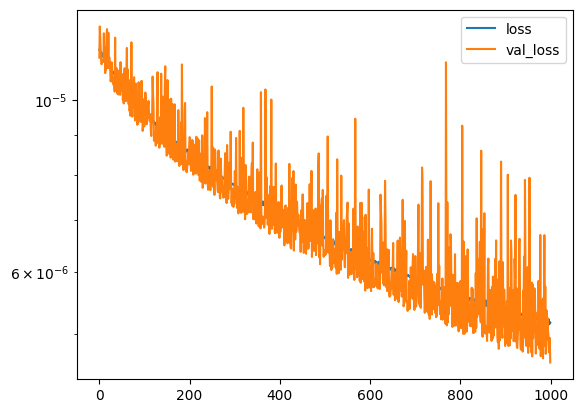

In [59]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
ax.set_yscale("log")

In [60]:
scaled_pred = model(scaled_inputs[~train_mask])
pred = loc + scale * scaled_pred

In [61]:
error = np.array(pred - outputs[~train_mask])

In [62]:
np.quantile(error, [.16, .5, .84], axis=0)

array([[-1.77717209e-03, -2.56729126e-03, -1.63674355e-03],
       [ 4.19616699e-05, -9.87052917e-05,  1.75490975e-04],
       [ 1.89971924e-03,  2.63130665e-03,  2.02256199e-03]])

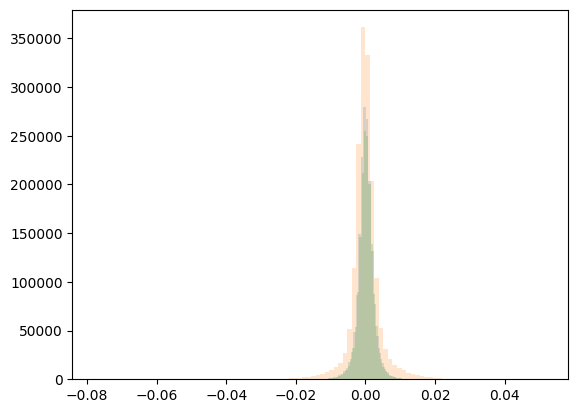

In [63]:
fig, ax = plt.subplots()

for err in error.T:
    ax.hist(err, bins=100, alpha=0.2);

In [64]:
model.save_weights("../src/celestify/data/bc_weights.h5")

In [65]:
import h5py

In [66]:
with h5py.File("../src/celestify/data/bc_weights.h5", "a") as file:
    file.create_group("input_scaling")
    file["input_scaling"].create_dataset("minval", data=minval)
    file["input_scaling"].create_dataset("maxval", data=maxval)

    file.create_group("output_rescaling")
    file["output_rescaling"].create_dataset("loc", data=loc)
    file["output_rescaling"].create_dataset("scale", data=scale)


In [67]:
with h5py.File("../src/celestify/data/bc_weights.h5", "r") as file:
    print(file["dense"]["dense"].keys())

<KeysViewHDF5 ['bias:0', 'kernel:0']>


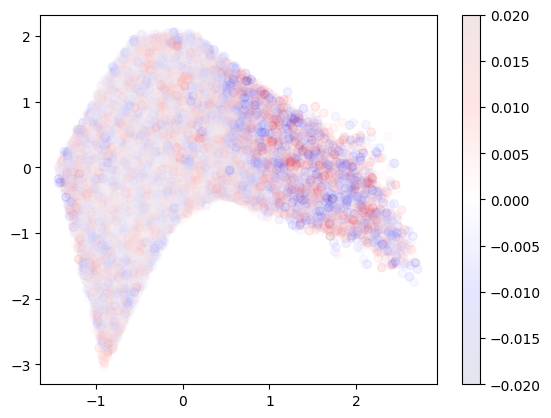

In [80]:
fig, ax = plt.subplots()

G = scaled_outputs[~train_mask, 0]
BP_RP = scaled_outputs[~train_mask, 2] - scaled_outputs[~train_mask, 1]
s = ax.scatter(BP_RP[::100], G[::100], c=error[::100, 0], alpha=0.1, vmin=-0.02, vmax=0.02, cmap="seismic")
fig.colorbar(s);

In [105]:
scaled_pred_train = model(scaled_inputs[train_mask])
pred_train = loc + scale * scaled_pred_train
train_error = np.array(pred_train - outputs[train_mask])

(2500.0, 7000.0)

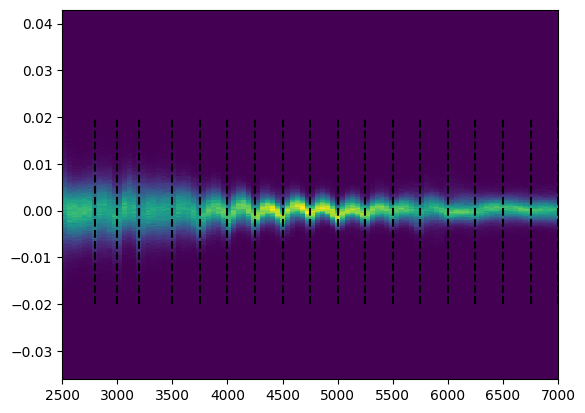

In [109]:
fig, ax = plt.subplots()
ax.hist2d(inputs[train_mask, 0], train_error[:, 0], bins=500)
ax.vlines(points[0], -0.02, 0.02, colors="k", ls="--")
ax.set_xlim(2500., 7000.)
# ax.set_xscale("log")

(2500.0, 7000.0)

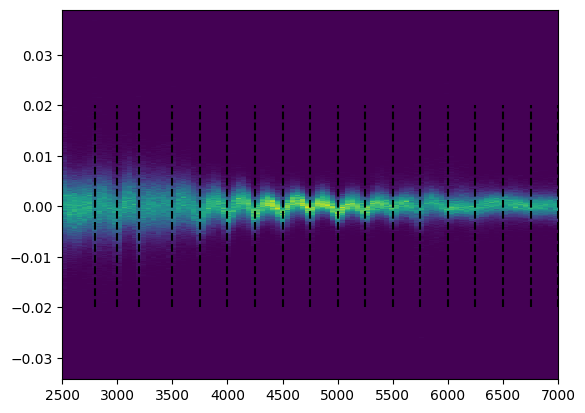

In [104]:
fig, ax = plt.subplots()
ax.hist2d(inputs[~train_mask, 0], error[:, 0], bins=500)
ax.vlines(points[0], -0.02, 0.02, colors="k", ls="--")
ax.set_xlim(2500., 7000.)
# ax.set_xscale("log")

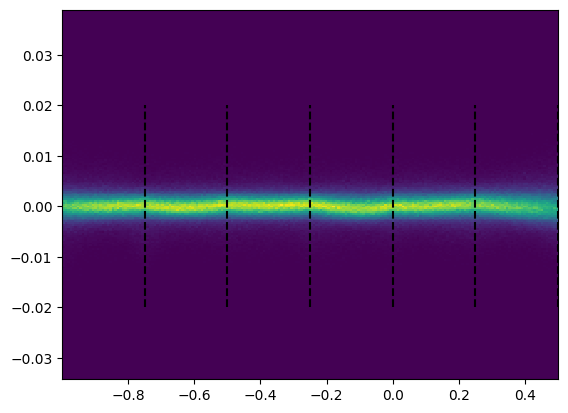

In [101]:
fig, ax = plt.subplots()
ax.hist2d(inputs[~train_mask, 2], error[:, 0], bins=200)
ax.vlines(points[2], -0.02, 0.02, colors="k", ls="--");

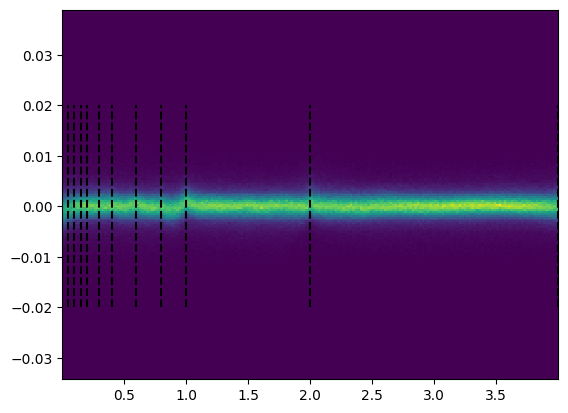

In [102]:
fig, ax = plt.subplots()
ax.hist2d(inputs[~train_mask, 3], error[:, 0], bins=200)
ax.vlines(points[3], -0.02, 0.02, colors="k", ls="--");

In [110]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 3)                 1